In [15]:
import logging

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
from skimage.transform import resize as resize_image

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import pyjet.backend as J

import copy

import data_utils as dsb

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# Set up some globals
SEED = 42
np.random.seed(SEED)



NUM_CHANNELS = 3

PATH_TO_TRAIN = '../input/train/'
PATH_TO_TEST = '../input/test/'

NUM_TRAIN = 670
NUM_TEST = 65

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the clusters
train_cluster_ids = np.load("../clusters/train_clusters.npz")
test_cluster_ids = np.load("../clusters/test_clusters.npz")


in_set = np.vectorize(lambda a, s: a in s)

In [5]:
# Load the training data
test_ids, X_test, sizes_test = dsb.load_test_data(path_to_test=PATH_TO_TEST, img_size=None,
                                                  num_channels=NUM_CHANNELS, mode='rgb')
train_ids, X_train, Y_train = dsb.load_train_data(path_to_train=PATH_TO_TRAIN, img_size=None,
                                                  num_channels=NUM_CHANNELS, mode='rgb')
print("Number of training samples: %s" % len(train_ids))
print("X-train shape: {}".format(X_train.shape))
print("Y-train shape: {}".format(Y_train.shape))
print("X-test shape: {}".format(X_test.shape))

# Get indexes from clusters
train_clusters = np.zeros(NUM_TRAIN, dtype=int)
test_clusters = np.zeros(NUM_TEST, dtype=int)
train_clusters[in_set(train_ids, {a for a in train_cluster_ids["cluster_0"]})]= 0
train_clusters[in_set(train_ids, {a for a in train_cluster_ids["cluster_1"]})]= 1
train_clusters[in_set(train_ids, {a for a in train_cluster_ids["cluster_2"]})]= 2

test_clusters[in_set(test_ids, {a for a in test_cluster_ids["cluster_0"]})]= 0
test_clusters[in_set(test_ids, {a for a in test_cluster_ids["cluster_1"]})]= 1
test_clusters[in_set(test_ids, {a for a in test_cluster_ids["cluster_2"]})]= 2

print(train_clusters)

2018-04-05 00:27:27,040 : INFO : Loading 65 test images with mode rgb


  0%|          | 0/65 [00:00<?, ?it/s]

 18%|█▊        | 12/65 [00:00<00:00, 119.43it/s]

 43%|████▎     | 28/65 [00:00<00:00, 137.63it/s]

 74%|███████▍  | 48/65 [00:00<00:00, 151.84it/s]

 92%|█████████▏| 60/65 [00:00<00:00, 142.72it/s]

100%|██████████| 65/65 [00:00<00:00, 145.05it/s]


2018-04-05 00:27:27,491 : INFO : Loading 670 train images with mode rgb


  0%|          | 0/670 [00:00<?, ?it/s]

  1%|▏         | 9/670 [00:00<00:08, 77.43it/s]

  2%|▏         | 13/670 [00:00<00:15, 41.57it/s]

  2%|▏         | 16/670 [00:00<00:31, 21.03it/s]

  3%|▎         | 18/670 [00:01<00:40, 16.23it/s]

  3%|▎         | 21/670 [00:01<00:41, 15.75it/s]

  4%|▍         | 26/670 [00:01<00:38, 16.78it/s]

  6%|▌         | 37/670 [00:01<00:28, 22.29it/s]

  6%|▋         | 42/670 [00:02<00:30, 20.33it/s]

  7%|▋         | 50/670 [00:02<00:26, 22.99it/s]

  9%|▊         | 57/670 [00:02<00:24, 24.84it/s]

  9%|▉         | 62/670 [00:02<00:26, 22.98it/s]

 10%|█         | 69/670 [00:02<00:24, 24.60it/s]

 11%|█         | 74/670 [00:03<00:24, 24.36it/s]

 12%|█▏        | 78/670 [00:03<00:24, 24.37it/s]

 13%|█▎        | 86/670 [00:03<00:23, 24.51it/s]

 14%|█▍        | 94/670 [00:03<00:22, 25.92it/s]

 15%|█▌        | 101/670 [00:03<00:21, 27.01it/s]

 16%|█▌        | 106/670 [00:03<00:20, 26.92it/s]

 17%|█▋        | 111/670 [00:04<00:21, 26.57it/s]

 17%|█▋        | 117/670 [00:04<00:20, 26.79it/s]

 18%|█▊        | 123/670 [00:04<00:20, 26.99it/s]

 19%|█▉        | 127/670 [00:04<00:20, 26.74it/s]

 19%|█▉        | 130/670 [00:04<00:20, 26.62it/s]

 20%|██        | 136/670 [00:05<00:20, 26.47it/s]

 21%|██        | 139/670 [00:05<00:21, 24.15it/s]

 22%|██▏       | 147/670 [00:05<00:20, 25.00it/s]

 23%|██▎       | 153/670 [00:05<00:20, 25.57it/s]

 24%|██▍       | 160/670 [00:06<00:19, 26.30it/s]

 25%|██▍       | 165/670 [00:06<00:19, 26.51it/s]

 26%|██▌       | 174/670 [00:06<00:19, 25.83it/s]

 27%|██▋       | 181/670 [00:06<00:18, 26.44it/s]

 28%|██▊       | 188/670 [00:06<00:17, 27.06it/s]

 29%|██▉       | 194/670 [00:07<00:17, 27.17it/s]

 30%|██▉       | 199/670 [00:07<00:17, 27.08it/s]

 30%|███       | 203/670 [00:07<00:17, 26.70it/s]

 31%|███▏      | 210/670 [00:07<00:16, 27.25it/s]

 32%|███▏      | 217/670 [00:07<00:16, 27.17it/s]

 33%|███▎      | 223/670 [00:08<00:16, 26.94it/s]

 34%|███▍      | 231/670 [00:08<00:16, 26.74it/s]

 35%|███▍      | 234/670 [00:08<00:16, 26.34it/s]

 36%|███▌      | 238/670 [00:09<00:16, 26.03it/s]

 36%|███▌      | 241/670 [00:09<00:16, 25.83it/s]

 37%|███▋      | 249/670 [00:09<00:16, 26.11it/s]

 38%|███▊      | 254/670 [00:09<00:15, 26.34it/s]

 39%|███▉      | 261/670 [00:09<00:15, 26.78it/s]

 40%|███▉      | 266/670 [00:09<00:15, 26.76it/s]

 40%|████      | 270/670 [00:10<00:14, 26.89it/s]

 41%|████      | 274/670 [00:10<00:14, 26.98it/s]

 41%|████▏     | 278/670 [00:10<00:15, 25.73it/s]

 42%|████▏     | 281/670 [00:11<00:15, 25.48it/s]

 43%|████▎     | 288/670 [00:11<00:15, 25.36it/s]

 44%|████▍     | 297/670 [00:11<00:14, 25.86it/s]

 45%|████▍     | 301/670 [00:11<00:14, 25.57it/s]

 46%|████▌     | 305/670 [00:12<00:14, 25.40it/s]

 47%|████▋     | 312/670 [00:12<00:14, 25.53it/s]

 47%|████▋     | 315/670 [00:12<00:14, 25.17it/s]

 48%|████▊     | 324/670 [00:12<00:13, 25.65it/s]

 49%|████▉     | 330/670 [00:12<00:13, 25.90it/s]

 50%|█████     | 337/670 [00:12<00:12, 26.23it/s]

 51%|█████     | 343/670 [00:13<00:12, 26.28it/s]

 52%|█████▏    | 348/670 [00:13<00:12, 26.19it/s]

 53%|█████▎    | 354/670 [00:13<00:11, 26.35it/s]

 54%|█████▎    | 359/670 [00:13<00:11, 26.22it/s]

 54%|█████▍    | 363/670 [00:13<00:11, 26.13it/s]

 55%|█████▍    | 366/670 [00:14<00:11, 26.00it/s]

 55%|█████▌    | 369/670 [00:14<00:11, 25.85it/s]

 56%|█████▋    | 377/670 [00:14<00:11, 26.22it/s]

 57%|█████▋    | 381/670 [00:14<00:11, 25.91it/s]

 58%|█████▊    | 387/670 [00:14<00:10, 26.13it/s]

 59%|█████▉    | 395/670 [00:15<00:10, 25.74it/s]

 60%|█████▉    | 399/670 [00:15<00:10, 25.04it/s]

 60%|██████    | 404/670 [00:16<00:10, 25.14it/s]

 61%|██████    | 409/670 [00:16<00:10, 25.05it/s]

 62%|██████▏   | 415/670 [00:16<00:10, 25.21it/s]

 63%|██████▎   | 419/670 [00:16<00:10, 24.87it/s]

 63%|██████▎   | 422/670 [00:17<00:10, 24.71it/s]

 64%|██████▍   | 432/670 [00:17<00:09, 25.14it/s]

 65%|██████▌   | 437/670 [00:17<00:09, 25.27it/s]

 66%|██████▋   | 445/670 [00:17<00:08, 25.35it/s]

 67%|██████▋   | 449/670 [00:17<00:08, 24.97it/s]

 68%|██████▊   | 454/670 [00:18<00:08, 25.08it/s]

 69%|██████▉   | 461/670 [00:18<00:08, 25.33it/s]

 70%|██████▉   | 466/670 [00:18<00:08, 25.31it/s]

 71%|███████   | 474/670 [00:18<00:07, 25.60it/s]

 72%|███████▏  | 480/670 [00:18<00:07, 25.42it/s]

 72%|███████▏  | 485/670 [00:19<00:07, 24.87it/s]

 73%|███████▎  | 489/670 [00:19<00:07, 24.66it/s]

 73%|███████▎  | 492/670 [00:20<00:07, 23.98it/s]

 74%|███████▍  | 496/670 [00:20<00:07, 23.91it/s]

 76%|███████▌  | 506/670 [00:20<00:06, 24.27it/s]

 76%|███████▋  | 511/670 [00:20<00:06, 24.38it/s]

 77%|███████▋  | 516/670 [00:21<00:06, 24.48it/s]

 78%|███████▊  | 521/670 [00:21<00:06, 24.24it/s]

 79%|███████▊  | 527/670 [00:21<00:05, 24.39it/s]

 79%|███████▉  | 531/670 [00:21<00:05, 24.42it/s]

 80%|████████  | 537/670 [00:21<00:05, 24.57it/s]

 81%|████████  | 543/670 [00:21<00:05, 24.71it/s]

 82%|████████▏ | 548/670 [00:22<00:04, 24.82it/s]

 83%|████████▎ | 554/670 [00:22<00:04, 24.97it/s]

 84%|████████▎ | 561/670 [00:22<00:04, 24.99it/s]

 84%|████████▍ | 566/670 [00:23<00:04, 24.05it/s]

 85%|████████▌ | 570/670 [00:24<00:04, 23.75it/s]

 86%|████████▌ | 573/670 [00:24<00:04, 23.70it/s]

 87%|████████▋ | 581/670 [00:24<00:03, 23.92it/s]

 87%|████████▋ | 585/670 [00:24<00:03, 23.88it/s]

 89%|████████▊ | 594/670 [00:24<00:03, 24.14it/s]

 90%|████████▉ | 602/670 [00:24<00:02, 24.29it/s]

 91%|█████████ | 607/670 [00:25<00:02, 24.20it/s]

 92%|█████████▏| 614/670 [00:25<00:02, 24.38it/s]

 92%|█████████▏| 619/670 [00:25<00:02, 24.44it/s]

 93%|█████████▎| 624/670 [00:25<00:01, 24.52it/s]

 94%|█████████▍| 632/670 [00:25<00:01, 24.73it/s]

 95%|█████████▌| 639/670 [00:25<00:01, 24.87it/s]

 97%|█████████▋| 647/670 [00:25<00:00, 25.08it/s]

 97%|█████████▋| 653/670 [00:26<00:00, 24.71it/s]

 98%|█████████▊| 658/670 [00:26<00:00, 24.58it/s]

 99%|█████████▉| 662/670 [00:26<00:00, 24.52it/s]

100%|█████████▉| 667/670 [00:27<00:00, 24.49it/s]

100%|██████████| 670/670 [00:27<00:00, 24.55it/s]

Number of training samples: 670
X-train shape: (670,)
Y-train shape: (670,)
X-test shape: (65,)
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 1 0 1 0 2 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2
 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 2 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 2 1 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 1 0 1 1 0 0 0 0 0 1 0 2 2 0 0 0 0 0 1 0
 0 0

Get some image loading setup

In [35]:
# Get the style images
style_images = np.concatenate([X_train[train_clusters == 0], X_test[test_clusters == 0]], axis=0)
content_images = np.concatenate([X_train[train_clusters != 0], X_test[test_clusters != 0]], axis=0)

NUM_TRAIN_STYLE = np.count_nonzero(train_clusters == 0)
NUM_TRAIN_CONTENT = np.count_nonzero(train_clusters != 0)
NUM_TEST_STYLE = np.count_nonzero(test_clusters != 0)
NUM_TEST_CONTENT = np.count_nonzero(test_clusters != 0)


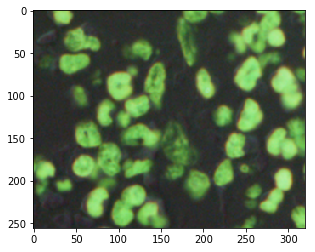

In [8]:
import matplotlib.animation as animation

i = 0


fig = plt.figure()
img_1 = style_images[i]
im = plt.imshow(img_1, animated=True)

def updatefig(*args):
    global i
    i = i + 1 % len(style_images)
    im.set_data(style_images[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)

j = 0
im = plt.imshow(content_images[j], animated=True)

def updatefig(*args):
    global j
    j = j + 1 % len(content_images)
    im.set_data(content_images[j])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
# This does not work

In [41]:
# Content loss only has 1 target since there's only one content image
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion((input * self.weight).expand_as(self.target), self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

    
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=B)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a, b, c * d)  # resise F_XL into \hat F_XL

        G = torch.bmm(features, features.transpose(1, 2))  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, weight):
        super(StyleLoss, self).__init__()
        self.G_input = None
        self.G_targets = None
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input, targets):
        self.output = input.clone()
        # Take gram of input and target
        self.G_input = self.gram(input)
        self.G_target = self.gram(targets).detach()
        # Apply the weight
        self.G_input.mul_(self.weight)
        self.G_target.mul_(self.weight)
        # First average target, or average criterion? Let's try average criterion
        # Since self.G_input has batch size of 1, broadcasting should happen
        self.loss = self.criterion(self.G_input.expand_as(self.G_target), self.G_target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [8]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if J.use_cuda:
    cnn = cnn.cuda()

In [9]:
print(repr(cnn))

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  

In [58]:
def get_input_param_optimizer(input_tensor):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_tensor.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

class StyleTransferModel(nn.Module):
    
    def __init__(self, content_layers, style_layers, content_weight=1, style_weight=1000):
        super(StyleTransferModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        assert all("conv" in l for l in content_layers)
        assert all("conv" in l for l in style_layers)
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.content_losses = [None] * len(content_layers)
        self.style_losses = [None] * len(style_layers)
        self.model = None
    
    def compile(self, content_img, base_model):
        
        assert content_img.shape[3] == 3
        assert content_img.ndim == 4
        content_img = content_img.transpose(0, 3, 1, 2)
        
        self.model = nn.ModuleList()  # the new network
        content_count = 0
        style_count = 0
        i = 1
        content_hidden = Variable(J.from_numpy(content_img.astype(np.float32) / 255.))
        for layer in base_model:
            # Get the intermediate content values
            content_hidden = layer(content_hidden)
            # Add the layer to the model and create name
            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(i)
                self.model.add_module(name=name, module=layer)
                
                # Check if its a content layer
                if name in self.content_layers:
                    print("Adding layer", name, "to content losses")
                    content_loss = ContentLoss(content_hidden, self.content_weight)
                    self.model.add_module(name="content_loss_" + str(i), module=content_loss)
                    self.content_losses[content_count] = content_loss
                    content_count += 1
                # Check if its a style layer
                if name in self.style_layers:
                    print("Adding layer", name, "to content losses")
                    style_loss = StyleLoss(self.style_weight)
                    self.model.add_module(name="style_loss_" + str(i), module=style_loss)
                    self.style_losses[style_count] = style_loss
                    style_count += 1
                # Check if we're done
                if content_count == len(self.content_losses) and style_count == len(self.style_losses):
                    break
            
            if isinstance(layer, nn.ReLU):
                name = "relu_" + str(i)
                self.model.add_module(name=name, module=layer)
                i += 1
                
            if isinstance(layer, nn.MaxPool2d):
                name = "max_pool2d_" + str(i)
                self.model.add_module(name=name, module=layer)
                
        # Turn the losses into module lists
        self.content_losses = nn.ModuleList(self.content_losses)
        self.style_losses = nn.ModuleList(self.style_losses)
        
        print("Content_Losses")
        print(repr(self.content_losses))
        
        print("Style Losses")
        print(repr(self.style_losses))
        
        print("Model:")
        print(repr(self.model))
    
    def forward(self, x, targets):
        for name, layer in self.model._modules.items():
            # The only case we need to worry about it the style loss
            if "style_loss" in name:
                x = layer(x, targets)
            elif "content_loss" in name:
                x = layer(x)
            # All other layers, run everything through
            else:
                x = layer(x)
                targets = layer(targets)
        
    def backward(self):
        content_loss_value = 0
        style_loss_value = 0
        for loss in self.content_losses:
            content_loss_value += loss.backward()
        for loss in self.style_losses:
            style_loss_value += loss.backward()
        return content_loss_value, style_loss_value
    
    def run_model(self, content_img, style_imgs, num_steps=300, batch_size=32):
        assert self.model is not None, "Compile the model first"
        print("Compiling the input image...")
        
        style_imgs = np.stack([resize_image(img, content_img.shape[1:3], mode='constant', preserve_range=True).astype(np.int8) 
                               for img in style_imgs])
        
        assert content_img.shape[3] == 3
        assert content_img.ndim == 4
        content_img = content_img.transpose(0, 3, 1, 2)
        assert style_imgs.shape[3] == 3
        assert style_imgs.ndim == 4
        style_imgs = style_imgs.transpose(0, 3, 1, 2)
        
        assert style_imgs.shape[1:] == content_img.shape[1:] == (3, 256, 320), \
            "content images: {}, style_images: {}".format(content_img.shape, style_imgs.shape)
        
        input_tensor = Variable(J.from_numpy(content_img.astype(np.float32) / 255.))
        input_param, optimizer = get_input_param_optimizer(input_tensor)
        
        inds = np.random.randint(len(style_imgs), size=batch_size)
        style_tensors = Variable(J.from_numpy(style_imgs[inds].astype(np.float32) / 255.))
        # style_tensors = Variable(J.from_numpy(style_imgs.astype(np.float32) / 255.))
        
        print("Optimizing...")
        run = [0]
        while run[0] <= num_steps:
            
            # Get the next set of style images
            # inds = np.random.randint(len(style_imgs), size=batch_size)
            # style_tensors = Variable(J.from_numpy(style_imgs[inds].astype(np.float32) / 255.))
            
            def closure():
                # Correct the values of the updated input image
                input_param.data.clamp_(0, 1)

                optimizer.zero_grad()
                self(input_param, style_tensors)
                style_score = 0
                content_score = 0

                # Run the backward pass
                content_score, style_score = self.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.data[0], content_score.data[0]))
                    print()

                return style_score + content_score
            
            optimizer.step(closure)

        # a last correction...
        input_param.data.clamp_(0, 1)

        return (J.to_numpy(input_param.data) * 255).astype(np.int8)


In [59]:
# Run on the first image
CONTENT_LAYERS = {'conv_4'}
STYLE_LAYERS =  {'conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'}
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1000

# Reset to put channels first
transfer_model = StyleTransferModel(CONTENT_LAYERS, STYLE_LAYERS, CONTENT_WEIGHT, STYLE_WEIGHT)
transfer_model.compile(content_images[0][np.newaxis], cnn)
new_image = transfer_model.run_model(content_images[0][np.newaxis], style_images)

plt.imshow(new_image)
plt.show()

Adding layer conv_1 to content losses
Adding layer conv_2 to content losses
Adding layer conv_3 to content losses
Adding layer conv_4 to content losses
Adding layer conv_4 to content losses
Adding layer conv_5 to content losses
Content_Losses
ModuleList(
  (0): ContentLoss(
    (criterion): MSELoss(
    )
  )
)
Style Losses
ModuleList(
  (0): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
  (1): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
  (2): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
  (3): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
  (4): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
)
Model:
ModuleList(
  (conv_1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (gram): GramMatrix(
    )
    (criterion): MSELoss(
    )
  )
  (relu_1): ReLU(inplace)
  (conv_2): Conv2d (64

Optimizing...


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58